# Comparing Prediction Methods

The purpose of this part of the code is to select the optimal forecasting method based on the set of 'train_target1.xlsx' on the basis of analysing this data and comparing the errors generated by particular methods.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data

The first step is to load data from excel file 'train_target1.xlsx' and present 'target1' on the distribution plot.

In [6]:
df = pd.read_excel('train_target1.xlsx',sheet_name='Sheet1')

C:\Users\xyz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target1', ylabel='Density'>

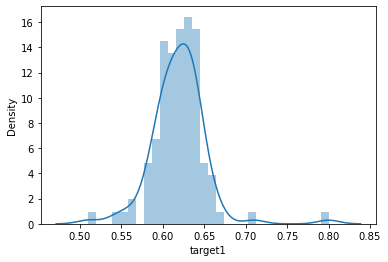

In [7]:
sns.distplot(df['target1'], bins=30)

On the chart above, there are heavy tails. These observations may affect the accuracy of the forecast. I'll deal with them later in the code.

# Data Standarization

If the data were measured on different scales, it makes sense to standardize them. I'm using StandardScaler() to standardize them by converting data on a unit scale (mean=0 and variance=1), which is a condition for optimal performance of many machine learning algorithms.

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
df.columns[:]

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'target1',
       'Sampling Time'],
      dtype='object')

In [10]:
standardized_data = StandardScaler().fit_transform(df[df.columns[:-2]])

In [11]:
df[df.columns[:-2]] = pd.DataFrame(data = standardized_data, columns = df.columns[:-2])

# Principle Component Analysis Projection to 2D

For a lot of machine learning applications PCA helps to visualize data. Dimensionality reduction is the process of reducing the number of random variables under consideration, via obtaining a set of principal variables In this case, I'm reducing the number of variables from 29 to 2 using PCA(). This may result in a better understanding of the data.

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)

In [14]:
principalComponents = pca.fit_transform(df[df.columns[:-2]])

In [15]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [16]:
finalDf = pd.concat([principalDf, df[['target1']]], axis = 1)

Text(0, 0.5, 'principal component 2')

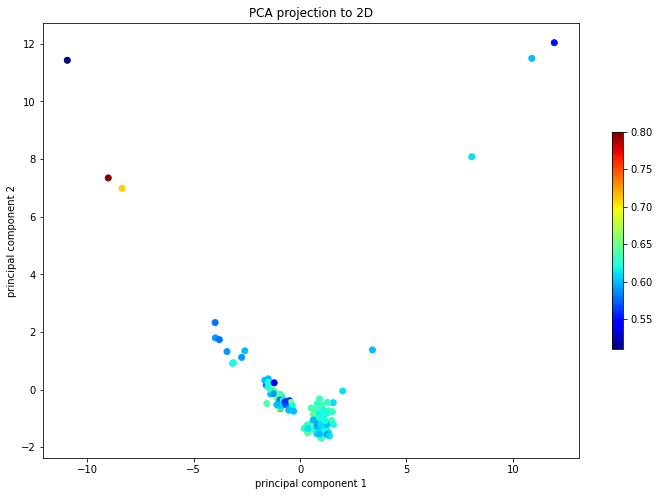

In [17]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
p = ax.scatter(finalDf['principal component 1']
               , finalDf['principal component 2'], c=df['target1'], cmap='jet')
cb = fig.colorbar(p, shrink=0.5)
ax.set_title('PCA projection to 2D')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

The above plot shows that some of the outlier observations are related to another value of 'target1' than most points.

# Delating Outliers

The purpose is to eliminate the heavy tails of 'target1' distribution plot. First, using sigma_clip() I classify which points delete due to exceeding the standard deviation of 3, and then I delete the given observation using drop().

In [18]:
from astropy.stats import sigma_clip
filtered_data = sigma_clip(df['target1'], sigma=3, maxiters=5)

In [19]:
index_to_remove = list(df[filtered_data.mask].index)

In [20]:
df['target1'][index_to_remove]

67     0.51
68     0.80
69     0.71
86     0.54
106    0.55
Name: target1, dtype: float64

In [21]:
df = df.drop(index_to_remove)

C:\Users\xyz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target1', ylabel='Density'>

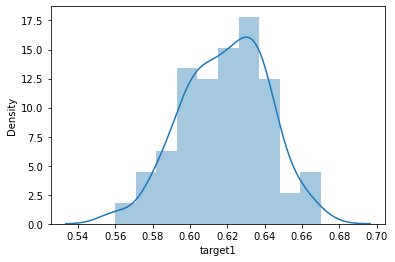

In [22]:
sns.distplot(df['target1'], bins=10)

Now, the distribution plot of 'target1' is much more similar to normal distribution.

# Splitting Data

In this section I divide the data into a training set and a test set. I decided not to use the commonly used way of dividing the set using train_test_split(). Since the model is ultimately designed to forecast data from a different time period, I decided to split the set by chronology as the most sensible way to do so. Therefore, train1 includes all observations from September, train2 includes all observations from August and September. While the test1 includes observations from August, test2 includes observations from October. In linear, ridge and lasso regression I am using train2 and test2 sets. But in others observations I use train1 and test1 to find optimal parameters. Later I use train2 and test2 set to fit data to model with established parameters before.

In [23]:
x_train1 = df[26:83][df.columns[:-2]]
y_train1 = df[26:83]['target1']

In [24]:
x_train2 = df[:83][df.columns[:-2]]
y_train2 = df[:83]['target1']

In [25]:
x_test1 = df[:26][df.columns[:-2]]
y_test1 = df[:26]['target1']

In [26]:
x_test2 = df[83:][df.columns[:-2]]
y_test2 = df[83:]['target1']

# Linear Regression

The first method considered is the simplest linear regression. LinearRegression(), that I use, fits a linear model to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
linear = LinearRegression(normalize = True)

In [29]:
linear.fit(x_train2,y_train2)

C:\Users\xyz\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [30]:
linear_predictions = linear.predict(x_test2)

# Ridge Regression

RidgeCV() regression is similar to the first method, the difference is that ridge regression minimize function below:

    ||y - Xw||^2 + alpha * ||w||^2

In particulary example below I decided to consider different alphas from np.linspace(0.01,0.5,50) in purpose to find the best alpha.

In [31]:
from sklearn.linear_model import RidgeCV

In [32]:
alphas = np.linspace(0.01,0.5,50)

In [33]:
ridge = RidgeCV(alphas = alphas, normalize = True)

In [34]:
ridge.fit(x_train2,y_train2)

C:\Users\xyz\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
        normalize=True)

In [35]:
ridge_predictions = ridge.predict(x_test2)

# Lasso Regression

The lasso regression belongs to the same reguralization family, but minimize different function:

    (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||

In this example I have also decided to consider different alphas from np.linspace(0.01,0.5,50) in purpose to find the best alpha.

In [36]:
from sklearn.linear_model import LassoCV

In [37]:
alphas = np.linspace(0.01,0.5,50)

In [38]:
lasso = LassoCV(normalize = True, max_iter = 10000)

In [39]:
lasso.fit(x_train2,y_train2)

C:\Users\xyz\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(max_iter=10000, normalize=True)

In [40]:
lasso_predictions = lasso.predict(x_test2)

# ElasticNet Regression

The ElasticNet regression is combines lasso regression with ridge regression. The ElasticNet regression minimize function below:

    1 / (2 * n_samples) * ||y - Xw||^2 
    + alpha * l1_ratio * ||w|| 
    + 0.5 * alpha * (1 - l1_ratio) * ||w||^2

In this example I have decided to consider different alphas from np.linspace(0.01,0.5,50) and different l1_ratio from np.linspace(0.01,1,50) in purpose to find the best parameters.

In [41]:
from sklearn.linear_model import ElasticNetCV

In [42]:
alphas = np.linspace(0.01,0.5,50)

In [43]:
l1_ratio = np.linspace(0.01,1,50)

In [44]:
ElasticNet = ElasticNetCV(normalize = True, max_iter = 10000)

In [45]:
ElasticNet.fit(x_train2, y_train2)

C:\Users\xyz\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


ElasticNetCV(max_iter=10000, normalize=True)

In [46]:
ElasticNet_predictions = ElasticNet.predict(x_test2)

In [47]:
ElasticNet.alpha_

0.0008876993863079455

# Support Vector Regression

The next method considered is non-linear regression. This model is created by using SVR(). The two most important parameters in this function are C and epsilon. I have created loops to select the parameters that give the smallest MSE.

In [48]:
from sklearn.svm import SVR

In [49]:
svr_parameters = np.zeros([500, 100])

In [50]:
for i in range(0,500):
    for j in range(0,100):
        svr = SVR(C=(i+1)/100, epsilon=(j+1)/100, gamma = 'scale')
        svr.fit(x_train1,y_train1)
        svr_predictions = svr.predict(x_test1)
        svr_parameters[i][j] = metrics.mean_squared_error(y_test1, svr_predictions)

In [51]:
np.where(svr_parameters == svr_parameters.min())

(array([145], dtype=int64), array([0], dtype=int64))

In [52]:
svr_parameters.min()

0.00019985491088887392

In [53]:
c=(np.where(svr_parameters == svr_parameters.min())[0][0]+1)/100

In [54]:
e=(np.where(svr_parameters == svr_parameters.min())[1][0]+1)/100

In [55]:
svr = SVR(C=c, epsilon=e, gamma = 'scale')

In [56]:
svr.fit(x_train2,y_train2)

SVR(C=1.46, epsilon=0.01)

In [57]:
svr_predictions = svr.predict(x_test2)

In [58]:
metrics.mean_squared_error(y_test2, svr_predictions)

0.0003599399995292377

# K-Nearest Neighbors Regression

Next regression is based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set. The key parameter is here n_neighbors, which means number of neighbors to use in model. To select the best parameter I'm also considering different values in loop.

In [59]:
from sklearn.neighbors import KNeighborsRegressor

In [60]:
knn_errors = []
for i in range(1,40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(x_train1, y_train1)
    knn_predictions = knn.predict(x_test1)
    knn_errors.append(metrics.mean_squared_error(y_test1, knn_predictions))

In [61]:
np.array(knn_errors).min()

0.00011772346153846139

In [62]:
np.where(np.array(knn_errors) == np.array(knn_errors).min())

(array([9], dtype=int64),)

In [63]:
k = np.where(np.array(knn_errors) == np.array(knn_errors).min())[0][0]+1

In [64]:
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(x_train2, y_train2)
knn_predictions = knn.predict(x_test2)
metrics.mean_squared_error(y_test2, knn_predictions)

0.00022495201052631647

# Decision Tree Regression

This method is decision tree. This method is used for classification and regression. The aim is to create a model that predicts the value of a target variable by learning simple decision-making rules based on data features. In this cause I use loop to select the most efficient max_depth parameter.

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
tree_errors = []
for i in range(1,5):
    tree = DecisionTreeRegressor(max_depth = i)
    tree.fit(x_train1, y_train1)
    tree_predictions = tree.predict(x_test1)
    tree_errors.append(metrics.mean_squared_error(y_test1, tree_predictions))

In [67]:
np.array(knn_errors).min()

0.00011772346153846139

In [68]:
np.where(np.array(tree_errors) == np.array(tree_errors).min())

(array([2], dtype=int64),)

In [69]:
k = np.where(np.array(tree_errors) == np.array(tree_errors).min())[0][0]+1

In [70]:
tree = DecisionTreeRegressor(max_depth = k)
tree.fit(x_train2, y_train2)
tree_predictions = tree.predict(x_test2)
metrics.mean_squared_error(y_test2, tree_predictions)

0.00019841903866809948

# Random Forest Regression

Last metod is random forest regression. It could be called extensive random tree regresion. It fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. In this cause I use loops to select the most efficient n_estimators and max_depth parameter.

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
forest_parameters = np.zeros([10, 3])

In [73]:
for i in range(0,10):
    for j in range(0,3):
        forest = RandomForestRegressor(n_estimators = (i+1)*10, max_depth = j+1, random_state=0)
        forest.fit(x_train1,y_train1)
        forest_predictions = forest.predict(x_test1)
        forest_parameters[i][j] = metrics.mean_squared_error(y_test1, forest_predictions)

In [74]:
np.where(forest_parameters == forest_parameters.min())

(array([1], dtype=int64), array([2], dtype=int64))

In [75]:
forest_parameters.min()

0.00020025548588871572

In [76]:
n_estimators = np.where(forest_parameters == forest_parameters.min())[0][0] + 1

In [77]:
max_depth = np.where(forest_parameters == forest_parameters.min())[1][0] + 1

In [78]:
forest = RandomForestRegressor(n_estimators = n_estimators*10, max_depth = max_depth, random_state=0)
forest.fit(x_train2,y_train2)
forest_predictions = forest.predict(x_test2)
metrics.mean_squared_error(y_test2, forest_predictions)

0.00019800497061891166

# Comparision

The last step is a comparison of the methods that have been determined on the training sets. The following errors relate to differences between the data that the model predicted and the actual data. To calculate those errors I use sklearn.metrics.

In [79]:
MAE=[]
MSE=[]
RMSE=[]
MAE.append(metrics.mean_absolute_error(y_test2, linear_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, ridge_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, lasso_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, ElasticNet_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, svr_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, knn_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, tree_predictions))
MAE.append(metrics.mean_absolute_error(y_test2, forest_predictions))

MSE.append(metrics.mean_squared_error(y_test2, linear_predictions))
MSE.append(metrics.mean_squared_error(y_test2, ridge_predictions))
MSE.append(metrics.mean_squared_error(y_test2, lasso_predictions))
MSE.append(metrics.mean_squared_error(y_test2, ElasticNet_predictions))
MSE.append(metrics.mean_squared_error(y_test2, svr_predictions))
MSE.append(metrics.mean_squared_error(y_test2, knn_predictions))
MSE.append(metrics.mean_squared_error(y_test2, tree_predictions))
MSE.append(metrics.mean_squared_error(y_test2, forest_predictions))

RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, linear_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, ridge_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, lasso_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, ElasticNet_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, svr_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, knn_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, tree_predictions)))
RMSE.append(np.sqrt(metrics.mean_squared_error(y_test2, forest_predictions)))

d = {'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}
pd.DataFrame(data=d, index=['linear', 'ridge', 'lasso', 'ElasticNet', 'svr', 'knn', 'tree', 'forest'])

,MAE,MSE,RMSE
linear,0.179686,0.174676,0.417942
ridge,0.050588,0.009654,0.098256
lasso,0.029874,0.003721,0.061004
ElasticNet,0.024115,0.002120,0.046047
svr,0.015398,0.000360,0.018972
knn,0.011346,0.000225,0.014998
tree,0.011222,0.000198,0.014086
forest,0.011838,0.000198,0.014071


Two of error counting methods indicate the lowest error in the random forest regression.

In [80]:
dict = {'y_test': y_test2, 'linear': linear_predictions, 'ridge': ridge_predictions, 'lasso': lasso_predictions, 'ElasticNet': ElasticNet_predictions, 'svr': svr_predictions, 'knn': knn_predictions, 'tree': tree_predictions, 'forest': forest_predictions}

In [81]:
pd.DataFrame(dict)

,y_test,linear,ridge,lasso,ElasticNet,svr,knn,tree,forest
87,0.61,0.611707,0.610149,0.612882,0.613692,0.617368,0.61774,0.608571,0.605367
88,0.61,0.570936,0.603311,0.613305,0.614411,0.622131,0.61044,0.608571,0.608076
89,0.60,0.591937,0.605780,0.611471,0.612760,0.614267,0.61713,0.608571,0.605530
90,0.62,0.603889,0.611719,0.613336,0.614177,0.634924,0.61965,0.608571,0.606230
91,0.61,0.618774,0.614673,0.614984,0.615646,0.637085,0.62329,0.608571,0.606230
92,0.62,0.597565,0.606342,0.613354,0.614214,0.628196,0.61965,0.608571,0.608076
93,0.62,0.592068,0.604500,0.612511,0.613411,0.621542,0.62332,0.608571,0.606499
94,0.61,0.600496,0.607445,0.613508,0.614380,0.624767,0.62597,0.608571,0.603638
95,0.63,0.583012,0.598507,0.614582,0.615225,0.606657,0.61666,0.608571,0.608076
96,0.62,0.584409,0.599283,0.614747,0.615542,0.621043,0.62184,0.608571,0.608076


So we choose the random forest regression model.